# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face Mask Segmentation
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder (1 mark)

In [0]:
import os

In [0]:
project_path = '/content/drive/My Drive/CV/Face Mask Segmentation/'

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [27]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

#data = # Open the file as readonly

img_arr = np.load(project_path+'images.npy',allow_pickle=True)
np_im = np.array(img_arr)
print (np_im.shape)

#img = Image.fromarray((img_arr * 255).astype(np.float32))

#img = Image.fromarray(img_arr)
#plt.imshow(img, cmap = "gray")


(409, 2)


### Check one sample from the loaded "images.npy" file  (2 marks)
Hint - print data[10][1] 

In [35]:
img_arr[10][1]

[{'imageHeight': 337,
  'imageWidth': 600,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}]}]

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(img_arr.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(img_arr.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(img_arr.shape[0]):
    img = img_arr[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in img_arr[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (2 marks)

In [39]:
X_train = np.array(X_train)
X_train.shape

(409, 224, 224, 3)

In [40]:
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

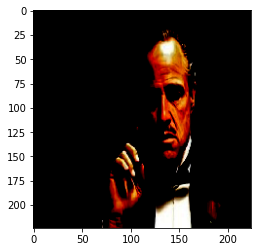

In [45]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

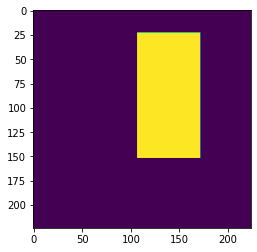

In [46]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable
    # model.summary()
    block_2 = model.get_layer("conv_pw_1_relu").output
    block_1 = model.get_layer("conv_pw_1_relu").output
    block0 = model.get_layer("conv_pw_3_relu").output
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block_1])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)
    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [122]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         

### Define dice coefficient function (10 marks)
- Create a function to calculate dice coefficient


In [0]:
from keras import backend as K

def dice_coefficient(y_true, y_pred):
    smooth = 1
   # num = y_true.size(0)

    m1 = K.flatten(y_true)
    m2 = K.flatten(y_pred)
    intersection = K.sum(m1 * m2)

    return (2. * intersection + smooth) / (K.sum(m1) + K.sum(m2) + smooth)

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (3 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
model.compile(loss=loss, metrics=[dice_coefficient], optimizer="adam")

### Define checkpoint and earlystopping

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (3 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [158]:
model.fit(X_train, masks, epochs=10, verbose=1, batch_size=1,  callbacks=[checkpoint, reduce_lr, stop])

Streaming output truncated to the last 5000 lines.
371/409 [==========================>...] - ETA: 1s - loss: 0.6030 - dice_coefficient: 0.6861
Epoch 00004: loss did not improve from 0.41642

Epoch 00004: loss did not improve from 0.41642
373/409 [==========================>...] - ETA: 1s - loss: 0.6035 - dice_coefficient: 0.6859
Epoch 00004: loss did not improve from 0.41642

Epoch 00004: loss did not improve from 0.41642
375/409 [==========================>...] - ETA: 1s - loss: 0.6040 - dice_coefficient: 0.6857
Epoch 00004: loss did not improve from 0.41642

Epoch 00004: loss did not improve from 0.41642
377/409 [==========================>...] - ETA: 1s - loss: 0.6022 - dice_coefficient: 0.6866
Epoch 00004: loss did not improve from 0.41642

Epoch 00004: loss did not improve from 0.41642
379/409 [==========================>...] - ETA: 1s - loss: 0.6020 - dice_coefficient: 0.6867
Epoch 00004: loss did not improve from 0.41642

Epoch 00004: loss did not improve from 0.41642
381/409 [

### Get the predicted mask for a sample image   (5 marks)

In [0]:
n = 10
sample_image = X_train[n]

ft = preprocess_input(np.array(sample_image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([sample_image]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

### Impose the mask on the image (5 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


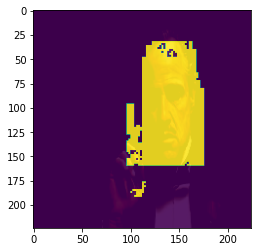

In [161]:
import matplotlib.pyplot as plt
out_image = sample_image
plt.imshow(out_image)
plt.imshow(pred_mask, alpha=0.9)